In [6]:
import HEKAimport
import glob
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import scipy

In [8]:
def loadHEKAFolder(filename):

    column_names = ['Filename', 'Group', 'Group_Index', 'Series', 'Series_Index']
    directory_df = pd.DataFrame(columns=column_names)


    for filename in glob.glob(filename):
        try:
            datafile = HEKAimport.HEKAfile(filename)
            for group in datafile.get_Groups():
                for series in group.Series:
                    directory_df.loc[len(directory_df)] = [filename, group.Label.split("\x00")[0], group.GroupCount, series.Label.split("\x00")[0], series.SeriesCount]





        except Exception as inst:
            print("Could not open "+filename)
            print(type(inst))
            print(inst.args)

    return directory_df 

In [9]:
def biexponential(x, a, b, m, n, c):
    return a*np.exp(-x/b) + m*np.exp(-x/n) + c
#x_dummy = np.linspace(start=0.001, stop=0.5, num=5000)

In [10]:
def triexponential(x, a, b, m, n, o,p, c):
    return a*np.exp(-x/b) + m*np.exp(-x/n) + o*np.exp(-x/p) + c
#x_dummy = np.linspace(start=0.001, stop=0.5, num=5000)

In [11]:
def exponential(x, a, b, c):
    return a*np.exp(-x/b) + c

In [12]:
# fit an exponential equation to selected data to obtain minimum "I_pA" value for IV curve
# creates a plot of the raw data and fit function
# If data can not be fitted, a mean value is calculated
# results in a pandas dataframe row for each trace containing I_pA, potential, unique name, animal and other ionformation
def fit_exp_get_min(directory_df, start=0, stop=14000, step=1, indices=[], pot=[], func=biexponential,\
                    calc_mean=False, bin=False, color="black"):
    #contains all information all selected traces
    data_IV = pd.DataFrame()
    #contains all information for each trace
    info={}
    
    # set bounds and  initial values if biexponental fit is selceted
    if func==biexponential:
        bounds=([0.0001, 0.0001,-300,0.01,-100],[np.inf,np.inf,-1,5,100])
        p0=[15, 0.01, -80, 0.04, -15]
        info["fit_func"] = "biexponential"

    # set bounds and  initial values if triexponental fit is selceted       
    if func==triexponential:
        bounds=([0.0001, 0.0001,-300,0.01,-200,0.0001, -100],[np.inf,np.inf,-1,5, -1, 0.5, 100])
        p0=[15, 0.01, -80, 0.04, -55, 0.015, -15]
        info["fit_func"] = "triexponential"

    
    # dummy data for plotting fit function
    x_dummy = np.linspace(start=0.001, stop=0.5, num=5000)
    
    # set list of indices per default to all indices
    if len(indices) == 0:
        indices = directory_df.index
    
    for i in indices:

        analysis_min = 0.015 #??
        analysis_max = 0.025 #??
        
        # select row
        selection = directory_df.query('index =='+str(i)+'')
        title='_'.join(map(str,(selection.iloc[0].values))).replace(".dat","").replace("data_10mMCa\\","").replace("_Cacna1hKO","")
        
        # set V_min, V_max
        V_min = selection["V_min"].values[0]
        V_max = selection["V_max"].values[0]

        if (V_min != "n" or V_max != "n"):
            datafile = HEKAimport.HEKAfile(selection["Filename"].values[0])
            data = datafile.get_Sweeps_byindex(int(selection["Group_Index"].values[0])-1,\
                                               int(selection["Series_Index"].values[0])-1, ZeroOffset=True)
            # drop "Leak_1" data, only keep "I-mon" data
            data_I = data.drop(['Leak_1'], axis=1)

            # list potentials
            a_series = pd.Series(np.asarray(datafile.get_IV(data[analysis_min:analysis_max]["I-mon"].idxmin().tolist(),\
                                int(selection["Group_Index"].values[0])-1, int(selection["Series_Index"].values[0])-1)),\
                                 index = data_I.columns, name="V")
            data_I = data_I.append(np.around(a_series,3), ignore_index=False)

            data_I.columns = data_I.iloc[len(data_I)-1]
            data_I = data_I.drop(data_I.index[len(data_I)-1])
            
            if len(pot) == 0:
                pot = data_I.columns
                
            for j in pot:
                if V_min <= j<= V_max:

                    info["Filename"] = selection["Filename"].values[0]
                    info["Group"] = selection["Group"].values[0]
                    info["Group_Index"] = selection["Group_Index"].values[0]
                    info["Series"] = selection["Series"].values[0]
                    info["Series_Index"] = selection["Series_Index"].values[0]
                    info["animal"] = selection["Filename"].values[0][29:36]
                    info["Name"] = info["animal"]+"_"+info["Group"]+\
                    "_"+str(info["Group_Index"])+\
                    "_"+str(info["Series_Index"])+\
                    "_"+info["Series"]

                    print(f">>>{title}: {j}")
                    y_data=data_I[j][start:stop:step].values
                    x_data=data_I[j][start:stop:step].index.values
                    
                    info["raw_data"] = data_I[j]
                    info["start"] = start
                    info["stop"] = stop
                    info["step"] = step


                    if calc_mean==False:
                        popt, pcov = scipy.optimize.curve_fit(func, x_data,\
                                                                      y_data, p0=p0, maxfev = 100000, bounds=bounds)

                        minimum = scipy.optimize.fmin(func, 0.05, args=tuple(popt))
                    print("-------")
                    
                    # create plot
                    #fig = plt.figure(figsize=(20,10))
                    plt.title(f">>>{title}: {j}")
                    if bin==False:
                        plt.plot(data_I[j][0:14000:step])
                        plt.xlim(-0.01,0.28)
                        plt.ylim(-100,50)
                    elif bin ==True:
                        binned=pd.DataFrame()
                        for b in range(0, 30500, 50):
                            indx = data_I[j].index[b]
                            mean = data_I[j][b:b+50].mean()
                            a = {'indx': [indx], 'mean': [mean]}
                            d = pd.DataFrame(data=a)
                            binned = pd.concat([binned,d], axis=0)
                        plt.plot(binned["indx"],binned["mean"], color=color, lw=0.2)
                        plt.xlim(-0.01,0.28)
                        plt.ylim(-100,50)
                        
                    
                    if calc_mean==False:
                        y_fit = func(x_dummy, *popt)
                        plt.scatter(x_dummy, y_fit, s=10, color="orange",zorder=3)

                    
                    
                    """if calc_mean==True:
                        mean=y_data.mean()
                        plt.axvline(x=x_data[0], color="green")
                        plt.axvline(x=x_data[-1], color="green")
                        plt.axhline(y=mean, color="red", ls="--", zorder=5)
                        plt.text(0.28,mean, f"mean: {mean} pA.....{j} V", fontsize= 20 )
                        print(f"mean= {mean}")
                        info["I_pA"] = mean
                        info["mean"] = mean
                        info["fit_popt"] = "n"
                    
                    else:
                        
                        # if not minimum can be found in fit function calculate mean
                        if np.isinf(func(minimum[0], *popt)) or func(minimum[0], *popt) < -200:
                            mean=y_data[0:int(5000/step)].mean()
                            plt.axvline(x=x_data[0], color="green")
                            plt.axvline(x=x_data[int(5000/step)], color="green")
                            plt.axhline(y=mean, color="red", ls="--", zorder=5)
                            plt.text(0.28,mean, f"mean: {mean} pA.....{j} V", fontsize= 20 )
                            print(f"mean= {mean}")
                            info["I_pA"] = mean
                            info["mean"] = mean
                            info["fit_popt"] = "n"

                        # minimum was succesfully determined 
                        else:
                            plt.axvline(x=x_data[0], color="green")
                            plt.axvline(x=x_data[-1], color="green")
                            plt.axvline(x=minimum[0],color = "red", zorder=4, ls="--")
                            plt.axhline(y=func(minimum[0], *popt),color = "red", zorder=5, ls="--")
                            plt.text(0.28,func(minimum[0], *popt), f"{func(minimum[0], *popt)} pA.....{j} V", fontsize= 20 )
                            print(f"minimum= {func(minimum[0], *popt)}")
                            info["I_pA"] = func(minimum[0], *popt)
                            info["mean"] = "n"
                            info["fit_popt"] = popt"""


                    """fig2 = plt.figure()
                    plt.scatter(x_data, func(np.asarray(list(x_data)), *popt)-np.asarray(list(y_data)),s=1)"""

                    info["V_V"] = j
                    data_IV = data_IV.append(pd.Series(info), ignore_index=True)
                    

        else:
            print(f"no analysis: {title}" )
            
    return data_I

In [13]:
# appends the dataframe row results from fit_exp_get_min() to one main data table
# checks whether the main data table already contains data that is about to be added
def append_to_df(data, data_to_add):
    keys=['Filename', 'Group', 'Group_Index', 'Series', 'Series_Index', 'V_V']
    df_duplicates=data.merge(data_to_add, on=keys, suffixes=('_left', '_right'))
    if len(df_duplicates)!=0:
        print("No addition of data to table due to duplicates")
        print("Duplicates:")
        print(df_duplicates.iloc[:, [0,1,2,4,5,6]])
        return data
    else:
        print("No duplicates!")
        data = data.append(data_to_add, ignore_index=True)
        print("Data was added to table.")
        return data

In [9]:
x_dummy = np.linspace(start=0, stop=0.5, num=5000)
y_dummy = biexponential(x_dummy, 3.69627982e+02, 2.05659047e-02, -2.99999999e+02,  3.22212522e-02, -1.63488484e+01)
"""ya_dummy = exponential(x_dummy, 15, 0.01, -15)
yb_dummy = exponential(x_dummy, -80, 0.04, -15)
noise = 5*np.random.normal(size=y_dummy.size)
#y_dummy = y_dummy + noise

plt.scatter(x_dummy, y_dummy, s=5)
plt.scatter(x_dummy, ya_dummy, s=5, color="red")
plt.scatter(x_dummy, yb_dummy, s=5, color="green")
plt.plot(data_I[-0.015][600:14000][::50],color="grey")
plt.scatter(x_dummy, y_fit, s=5, color="orange")

plt.xlim(-0.2,0.8)
plt.ylim(-200,100)"""

'ya_dummy = exponential(x_dummy, 15, 0.01, -15)\nyb_dummy = exponential(x_dummy, -80, 0.04, -15)\nnoise = 5*np.random.normal(size=y_dummy.size)\n#y_dummy = y_dummy + noise\n\nplt.scatter(x_dummy, y_dummy, s=5)\nplt.scatter(x_dummy, ya_dummy, s=5, color="red")\nplt.scatter(x_dummy, yb_dummy, s=5, color="green")\nplt.plot(data_I[-0.015][600:14000][::50],color="grey")\nplt.scatter(x_dummy, y_fit, s=5, color="orange")\n\nplt.xlim(-0.2,0.8)\nplt.ylim(-200,100)'

In [178]:
# load file that contains information about the traces that are to be included for analysis
directory_df=pd.read_excel("directory_df_KO_onlyIVShort_rec_for_analysis.xlsx", index_col=0)
directory_df

,Filename,Group,Group_Index,Series,Series_Index,V_min,V_max
0,data_10mMCa\211112_Cacna1hKO_4403_KO.dat,E-5,1,IV-short,1,-0.095,0.025
4,data_10mMCa\211112_Cacna1hKO_4403_KO.dat,E-5,1,IV-short,5,n,n
5,data_10mMCa\211112_Cacna1hKO_4403_KO.dat,E-6,2,IV-short,1,-0.095,0.035
8,data_10mMCa\211112_Cacna1hKO_4403_KO.dat,E-6,2,IV-short,4,n,n
10,data_10mMCa\211112_Cacna1hKO_4403_KO.dat,E-7,3,IV-short,1,n,n
11,data_10mMCa\211112_Cacna1hKO_4403_KO.dat,E-8,4,IV-short,1,n,n
13,data_10mMCa\211112_Cacna1hKO_4403_KO.dat,E-9,5,IV-short,1,n,n
14,data_10mMCa\211112_Cacna1hKO_4403_KO.dat,E-9,5,IV-short,2,n,n
15,data_10mMCa\211203_Cacna1hKO_4511_KO.dat,E-12,1,IV-short,1,-0.095,0.005
16,data_10mMCa\211203_Cacna1hKO_4511_KO.dat,E-13,2,IV-short,1,-0.095,-0.015


In [179]:
# selecting the file by index, that should be analyzed
index=56
directory_df.loc[index]

Filename        data_10mMCa\220303_Cacna1hKO_4533_KO.dat
Group                                               E-16
Group_Index                                            4
Series                                          IV-short
Series_Index                                           1
V_min                                             -0.095
V_max                                              0.025
Name: 56, dtype: object

In [180]:
# create an array with the potential range in which the data is to be analyzed
pot=[x / 1000.0 for x in range(-45, 55, 10)]
pot


[-0.045, -0.035, -0.025, -0.015, -0.005, 0.005, 0.015, 0.025, 0.035, 0.045]

>>>220303_4533_KO_E-16_4_IV-short_1_-0.095_0.025: -0.045
-------
>>>220303_4533_KO_E-16_4_IV-short_1_-0.095_0.025: -0.035
-------
>>>220303_4533_KO_E-16_4_IV-short_1_-0.095_0.025: -0.025
-------
>>>220303_4533_KO_E-16_4_IV-short_1_-0.095_0.025: -0.015
-------
>>>220303_4533_KO_E-16_4_IV-short_1_-0.095_0.025: -0.005
-------
>>>220303_4533_KO_E-16_4_IV-short_1_-0.095_0.025: 0.005
-------
>>>220303_4533_KO_E-16_4_IV-short_1_-0.095_0.025: 0.015
-------
>>>220303_4533_KO_E-16_4_IV-short_1_-0.095_0.025: 0.025
-------


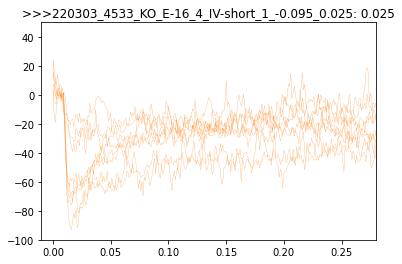

In [185]:
# get I_pA values either by fit or calculating the mean for selected potential traces
data_I=fit_exp_get_min(directory_df, start=100, stop=5000, step = 50, indices=[index], pot=pot, calc_mean=True, bin=True, color="tab:orange")


In [453]:
data_IV_40_KO_add["V_V"]

0    0.005
1    0.015
2    0.025
3    0.035
4    0.045
5    0.055
6    0.065
7    0.075
Name: V_V, dtype: float64

In [454]:
# append data to main data table
data_IV_40_KO = pd.read_excel("data_IV_40_KO.xlsx", index_col=0)
data_IV_40_KO = append_to_df(data_IV_40_KO,data_IV_40_KO_add)
data_IV_40_KO.to_excel("data_IV_40_KO.xlsx")  

No duplicates!
Data was added to table.


In [455]:
pd.set_option('display.max_rows', 8000)
len(data_IV_40_KO)

129

In [132]:
binned

,mean
indx,
0.000,5.172760
0.001,2.871545
0.002,0.676520
0.003,1.523547
0.004,-3.568610
...,...
0.605,17.910649
0.606,25.528896
0.607,28.052488


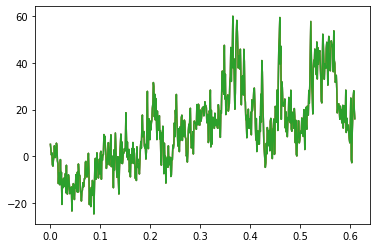

In [141]:
plt.plot(binned)
plt.plot(binned)
plt.plot(binned)